# Urban Sound 8K
This is an example using the Urban Sound 8K dataset from https://urbansounddataset.weebly.com/urbansound8k.html. This dataset consists of 8,732 samples of 4 seconds or less from 10 classes. Note that the official evaluation criteria for the dataset is a 10-fold cross validation while herte only a single fold is tested so the results here should not be directly compared with official results.

In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
from fastai_audio import *
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
plt.style.use('dark_background')

In [2]:
DATA = Path('/data/ai/datasets/urbansound8K')
(DATA/'audio').ls()[:5]

[PosixPath('/data/ai/datasets/urbansound8K/audio/fold1'),
 PosixPath('/data/ai/datasets/urbansound8K/audio/fold2'),
 PosixPath('/data/ai/datasets/urbansound8K/audio/fold5'),
 PosixPath('/data/ai/datasets/urbansound8K/audio/fold7'),
 PosixPath('/data/ai/datasets/urbansound8K/audio/fold10')]

In [3]:
df_inp = pd.read_csv(DATA/'metadata'/'UrbanSound8K.csv')
df_inp['filename'] = ('audio' + os.sep + 'fold' + df_inp.fold.astype(str) + os.sep + df_inp.slice_file_name)
df_inp.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class,filename
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark,audio/fold5/100032-3-0-0.wav
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing,audio/fold5/100263-2-0-117.wav
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing,audio/fold5/100263-2-0-121.wav
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing,audio/fold5/100263-2-0-126.wav
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing,audio/fold5/100263-2-0-137.wav


In [4]:
df = df_inp[['filename','class','fold']].reset_index(drop=True)
df['valid'] = df.fold == 10
df = df[['filename','class','valid','fold']]
df.head()

,filename,class,valid,fold
0,audio/fold5/100032-3-0-0.wav,dog_bark,False,5
1,audio/fold5/100263-2-0-117.wav,children_playing,False,5
2,audio/fold5/100263-2-0-121.wav,children_playing,False,5
3,audio/fold5/100263-2-0-126.wav,children_playing,False,5
4,audio/fold5/100263-2-0-137.wav,children_playing,False,5


In [5]:
df.valid.value_counts()

False    7895
True      837
Name: valid, dtype: int64

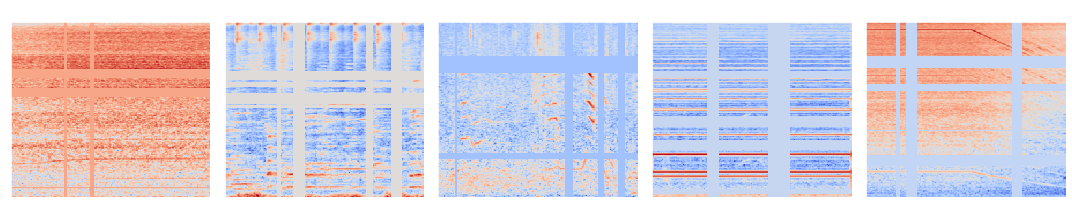

In [6]:
sr = 22050
tfms = [ToDevice('cuda:0'), ToMono(), Resample(sr), PadTo(sr*4), ToFreq(n_fft=2048, hop_length=512), ToMel(n_mels=256), ToDb()]
augs = [Mask(4, 20, 4, 10)]
data = (AudioList.from_df(df, path=DATA)
                 .split_from_df()
                 .label_from_df(label_cls=CategoryList)
                 .transform([tfms+augs,tfms])
                 .databunch(bs=64, num_workers=0))
data.show_batch()

In [9]:
import fastai.vision.models as models
lrn = audio_cnn_learner(data, models.resnet18, path='.', metrics=[accuracy], pretrained=True, callback_fns=[ShowGraph]).mixup()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.74E-03
Min loss divided by 10: 4.79E-03


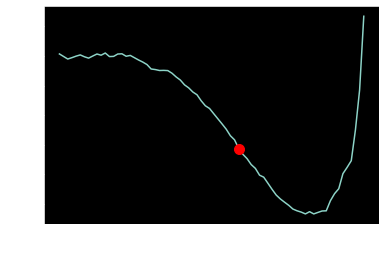

In [16]:
lrn.lr_find()
lrn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,time
0,1.769280,2.830892,0.469534,00:59
1,1.325500,2.113320,0.579450,00:35
2,1.076357,0.503646,0.853047,00:34
3,0.919067,0.578786,0.849462,00:34
4,0.821338,0.484176,0.868578,00:34


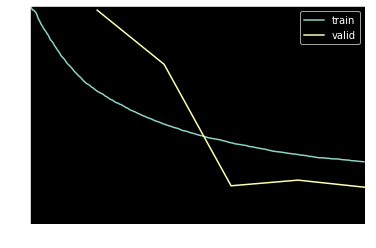

In [8]:
lrn.fit_one_cycle(5, 2e-3)

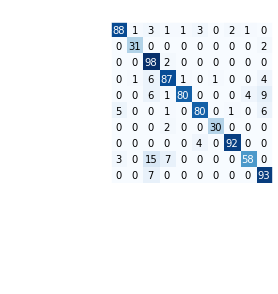

In [32]:
preds,y,losses = lrn.get_preds(with_loss=True)
interp = ClassificationInterpretation(lrn, preds, y, losses)
interp.plot_confusion_matrix()

In [25]:
lrn.save('resnet18_mixup_sa4')

Now reload the saved model and re-evaluate.

In [29]:
lrn2 = audio_cnn_learner(data, models.resnet18, path='.', metrics=[accuracy], pretrained=True, callback_fns=[ShowGraph]).mixup()
lrn2 = lrn2.load('resnet18_mixup_sa4')

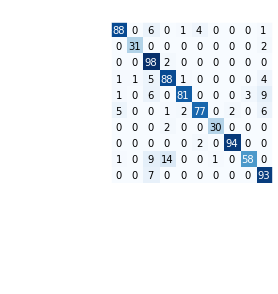

In [34]:
preds,y,losses = lrn2.get_preds(with_loss=True)
interp = ClassificationInterpretation(lrn2, preds, y, losses)
interp.plot_confusion_matrix()